In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math 
import numpy as np
from python_utils import *

In [2]:
data1="1055_tst_td_b_0081.wav"
ipd.Audio(data1)

Text(0, 0.5, 'Amplitude')

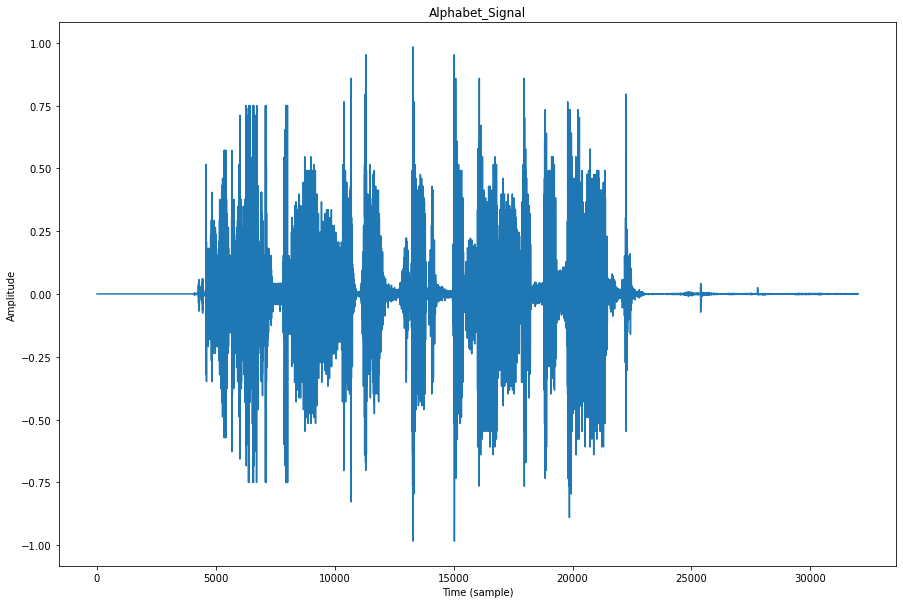

In [3]:
y , sr =librosa.load(data1,sr=8000)  
plt.figure(figsize=(15,10))
plt.plot(y)
plt.title('Alphabet_Signal')
plt.xlabel('Time (sample)')
plt.ylabel('Amplitude')

In [4]:
#j=-1 
from scipy.special import jv

def bessel(v, X):
    return ((1j ** (-v)) * jv(v, 1j * X)).real

def stft(x, n_fft=512, win_length=400, hop_length=160, window='hamming'):
    if window == 'hanning':
        window = np.hanning(win_length)
    elif window == 'hamming':
        window = np.hamming(win_length)
    elif window == 'rectangle':
        window = np.ones(win_length)
    return np.array(
        [np.fft.rfft(window * x[i:i + win_length], n_fft, axis=0) for i in range(0, len(x) - win_length, hop_length)])

In [5]:
def estnoisem(pSpectrum, hop_length):
    (nFrames, nFFT2) = np.shape(pSpectrum)  # number of frames and freq bins
    x = np.array(np.zeros((nFrames, nFFT2)))  # initialize output arrays
    xs = np.array(np.zeros((nFrames, nFFT2)))  # will hold std error in the future

    # default algorithm constants
    taca = 0.0449  # smoothing time constant for alpha_c = -hop_length/log(0.7) in equ (11)
    tamax = 0.392  # max smoothing time constant in (3) = -hop_length/log(0.96)
    taminh = 0.0133  # min smoothing time constant (upper limit) in (3) = -hop_length/log(0.3)
    tpfall = 0.064  # time constant for P to fall (12)
    tbmax = 0.0717  # max smoothing time constant in (20) = -hop_length/log(0.8)
    qeqmin = 2.0  # minimum value of Qeq (23)
    qeqmax = 14.0  # max value of Qeq per frame
    av = 2.12  # fudge factor for bc calculation (23 + 13 lines)
    td = 1.536  # time to take minimum over
    nu = 8  # number of subwindows
    qith = np.array([0.03, 0.05, 0.06, np.Inf], dtype=float)  # noise slope thresholds in dB/s
    nsmdb = np.array([47, 31.4, 15.7, 4.1], dtype=float)  # maximum permitted +ve noise slope in dB/s

    # derived algorithm constants
    aca = np.exp(-hop_length / taca)  # smoothing constant for alpha_c in equ (11) = 0.7
    acmax = aca  # min value of alpha_c = 0.7 in equ (11) also = 0.7
    amax = np.exp(-hop_length / tamax)  # max smoothing constant in (3) = 0.96
    aminh = np.exp(-hop_length / taminh)  # min smoothing constant (upper limit) in (3) = 0.3
    bmax = np.exp(-hop_length / tbmax)  # max smoothing constant in (20) = 0.8
    SNRexp = -hop_length / tpfall
    nv = round(td / (hop_length * nu))  # length of each subwindow in frames

    if nv < 4:  # algorithm doesn't work for miniscule frames
        nv = 4
        nu = round(td / (hop_length * nv))
    nd = nu * nv  # length of total window in frames
    (md, hd, dd) = mhvals(nd)  # calculate the constants M(D) and H(D) from Table III
    (mv, hv, dv) = mhvals(nv)  # calculate the constants M(D) and H(D) from Table III
    nsms = np.array([10]) ** (nsmdb * nv * hop_length / 10)  # [8 4 2 1.2] in paper
    qeqimax = 1 / qeqmin  # maximum value of Qeq inverse (23)
    qeqimin = 1 / qeqmax  # minumum value of Qeq per frame inverse

    p = pSpectrum[0, :]  # smoothed power spectrum
    ac = 1  # correction factor (9)
    sn2 = p  # estimated noise power
    pb = p  # smoothed noisy speech power (20)
    pb2 = pb ** 2
    pminu = p
    actmin = np.array(np.ones(nFFT2) * np.Inf)  # Running minimum estimate
    actminsub = np.array(np.ones(nFFT2) * np.Inf)  # sub-window minimum estimate
    subwc = nv  # force a buffer switch on first loop
    actbuf = np.array(np.ones((nu, nFFT2)) * np.Inf)  # buffer to store subwindow minima
    ibuf = 0
    lminflag = np.zeros(nFFT2)  # flag to remember local minimum

    # loop for each frame
    for t in range(0, nFrames):  # we use t instead of lambda in the paper
        pSpectrum_t = pSpectrum[t, :]  # noise speech power spectrum
        acb = (1 + (sum(p) / sum(pSpectrum_t) - 1) ** 2) ** (-1)  # alpha_c-bar(t)  (9)

        tmp = np.array([acb])
        tmp[tmp < acmax] = acmax
        # max_complex(np.array([acb] ),np.array([acmax] ))
        ac = aca * ac + (1 - aca) * tmp  # alpha_c(t)  (10)
        ah = amax * ac * (1 + (p / sn2 - 1) ** 2) ** (-1)  # alpha_hat: smoothing factor per frequency (11)
        SNR = sum(p) / sum(sn2)
        ah = max_complex(ah,
                         min_complex(np.array([aminh]), np.array([SNR ** SNRexp])))  # lower limit for alpha_hat (12)
        p = ah * p + (1 - ah) * pSpectrum_t  # smoothed noisy speech power (3)
        b = min_complex(ah ** 2,
                        np.array([bmax]))  # smoothing constant for estimating periodogram variance (22 + 2 lines)
        pb = b * pb + (1 - b) * p  # smoothed periodogram (20)
        pb2 = b * pb2 + (1 - b) * p ** 2  # smoothed periodogram squared (21)
        qeqi = max_complex(min_complex((pb2 - pb ** 2) / (2 * sn2 ** 2), np.array([qeqimax])),
                           np.array([qeqimin / (t + 1)]))  # Qeq inverse (23)
        qiav = sum(
            qeqi) / nFFT2  # Average over all frequencies (23+12 lines) (ignore non-duplication of DC and nyquist terms)
        bc = 1 + av * np.sqrt(qiav)  # bias correction factor (23+11 lines)
        bmind = 1 + 2 * (nd - 1) * (1 - md) / (
                    qeqi ** (-1) - 2 * md)  # we use the signalmplified form (17) instead of (15)
        bminv = 1 + 2 * (nv - 1) * (1 - mv) / (qeqi ** (-1) - 2 * mv)  # same expressignalon but for sub windows
        kmod = (bc * p * bmind) < actmin  # Frequency mask for new minimum

        if any(kmod):
            actmin[kmod] = bc * p[kmod] * bmind[kmod]
            actminsub[kmod] = bc * p[kmod] * bminv[kmod]

        if subwc > 1 and subwc < nv:  # middle of buffer - allow a local minimum
            lminflag = np.logical_or(lminflag, kmod)  # potential local minimum frequency bins
            pminu = min_complex(actminsub, pminu)
            sn2 = pminu.copy()
        else:
            if subwc >= nv:  # end of buffer - do a buffer switch
                ibuf = 1 + (ibuf % nu)  # increment actbuf storage pointer
                actbuf[ibuf - 1, :] = actmin.copy()  # save sub-window minimum
                pminu = min_complex_mat(actbuf)
                i = np.nonzero(np.array(qiav) < qith)
                nsm = nsms[i[0][0]]  # noise slope max
                lmin = np.logical_and(
                    np.logical_and(np.logical_and(lminflag, np.logical_not(kmod)), actminsub < (nsm * pminu)),
                    actminsub > pminu)
                if any(lmin):
                    pminu[lmin] = actminsub[lmin]
                    actbuf[:, lmin] = np.ones((nu, 1)) * pminu[lmin]
                lminflag[:] = 0
                actmin[:] = np.Inf
                subwc = 0
        subwc = subwc + 1
        x[t, :] = sn2.copy()
        qisq = np.sqrt(qeqi)
        # empirical formula for standard error based on Fig 15 of [2]
        xs[t, :] = sn2 * np.sqrt(
            0.266 * (nd + 100 * qisq) * qisq / (1 + 0.005 * nd + 6 / nd) / (0.5 * qeqi ** (-1) + nd - 1))

    return x

In [6]:
def mhvals(*args):
    nargin = len(args)

    dmh = np.array([
        [1, 0, 0],
        [2, 0.26, 0.15],
        [5, 0.48, 0.48],
        [8, 0.58, 0.78],
        [10, 0.61, 0.98],
        [15, 0.668, 1.55],
        [20, 0.705, 2],
        [30, 0.762, 2.3],
        [40, 0.8, 2.52],
        [60, 0.841, 3.1],
        [80, 0.865, 3.38],
        [120, 0.89, 4.15],
        [140, 0.9, 4.35],
        [160, 0.91, 4.25],
        [180, 0.92, 3.9],
        [220, 0.93, 4.1],
        [260, 0.935, 4.7],
        [300, 0.94, 5]
    ], dtype=float)

    if nargin >= 1:
        d = args[0]
        i = np.nonzero(d <= dmh[:, 0])
        if len(i) == 0:
            i = np.shape(dmh)[0] - 1
            j = i
        else:
            i = i[0][0]
            j = i - 1
        if d == dmh[i, 0]:
            m = dmh[i, 1]
            h = dmh[i, 2]
        else:
            qj = np.sqrt(dmh[i - 1, 0])  # interpolate usignalng sqrt(d)
            qi = np.sqrt(dmh[i, 0])
            q = np.sqrt(d)
            h = dmh[i, 2] + (q - qi) * (dmh[j, 2] - dmh[i, 2]) / (qj - qi)
            m = dmh[i, 1] + (qi * qj / q - qj) * (dmh[j, 1] - dmh[i, 1]) / (qi - qj)
    else:
        d = dmh[:, 0].copy()
        m = dmh[:, 1].copy()
        h = dmh[:, 2].copy()

    return m, h, d


def max_complex(a, b):
    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])
    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa > bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex(a, b):

    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])

    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa < bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex_mat(a):
    s = np.shape(a)
    m = np.array(np.zeros(s[1]))
    for i in range(0, s[1]):
        j = np.argmin(np.absolute(a[:, i]))
        m[i] = a[j, i]
    return m

E:\Anaconda\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


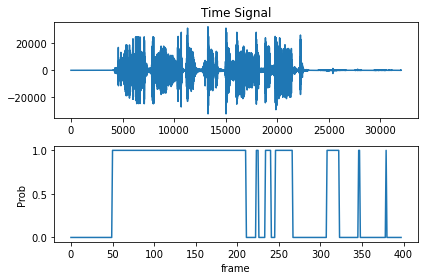

398
4000.0
500 3800

Total Intervals = 1


In [7]:
import os
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
#from utils.estnoise_ms import * 
import math
from pydub import AudioSegment
 
def VAD(signal, sr, nFFT=1024, win_length=0.025, hop_length=0.01, theshold=0.9):
    """Voice Activity Detector
    probRatio   : frame-based voice activity probability sequence
    """
    signal=signal.astype('float')

    maxPosteriorSNR= 1000   
    minPosteriorSNR= 0.0001    

    win_length_sample = round(win_length*sr)
    hop_length_sample = round(hop_length*sr)    

    # the variance of the speech; lambda_x(k)
    _stft = stft(signal, n_fft=nFFT, win_length=win_length_sample, hop_length=hop_length_sample)
    pSpectrum = np.abs(_stft) ** 2                     
    
    # estimate the variance of the noise using minimum statistics noise PSD estimation ; lambda_d(k). 
    estNoise = estnoisem(pSpectrum,hop_length)     
    estNoise = estNoise
    
    aPosterioriSNR=pSpectrum/estNoise                    
    aPosterioriSNR=aPosterioriSNR
    aPosterioriSNR[aPosterioriSNR > maxPosteriorSNR] = maxPosteriorSNR
    aPosterioriSNR[aPosterioriSNR < minPosteriorSNR] = minPosteriorSNR

    a01=hop_length/0.05     # a01=P(signallence->speech)  hop_length/mean signallence length (50 ms)
    a00=1-a01               # a00=P(signallence->signallence)
    a10=hop_length/0.1      # a10=P(speech->signallence) hop/mean talkspurt length (100 ms)
    a11=1-a10               # a11=P(speech->speech)

    b01=a01/a00
    b10=a11-a10*a01/a00
  
    smoothFactorDD=0.96
    previousGainedaPosSNR=1 
    (nFrames,nFFT2) = pSpectrum.shape                
    probRatio=np.zeros((nFrames,1))
    logGamma_frame=0
    for i in range(nFrames):                         
        aPosterioriSNR_frame = aPosterioriSNR[i,:]                  
        
        #operator [2](52)
        oper=aPosterioriSNR_frame-1
        oper[oper < 0] = 0 
        smoothed_a_priori_SNR = smoothFactorDD * previousGainedaPosSNR + (1-smoothFactorDD) * oper
        
        #V for MMSE estimate ([2](8)) 
        V=0.1*smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR)            
        
        #geometric mean of log likelihood ratios for individual frequency band  [1](4)
        logLRforFreqBins=2*V-np.log(smoothed_a_priori_SNR+1)              
        # logLRforFreqBins=np.exp(smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR))/(1+smoothed_a_priori_SNR)
        gMeanLogLRT=np.mean(logLRforFreqBins)       
        logGamma_frame=np.log(a10/a01) + gMeanLogLRT + np.log(b01+b10/( a10+a00*np.exp(-logGamma_frame) ) )
        probRatio[i]=1/(1+np.exp(-logGamma_frame))
        
        #Calculate Gain function which results from the MMSE [2](7).
        gain = (math.gamma(1.5) * np.sqrt(V)) / aPosterioriSNR_frame * np.exp(-1 * V / 2) * ((1 + V) * bessel(0, V / 2) + V * bessel(1, V / 2))
    
        previousGainedaPosSNR = (gain**2) * aPosterioriSNR_frame
        probRatio[probRatio>theshold]=1
        probRatio[probRatio<theshold]=0

    return probRatio

if __name__ == '__main__':
    path_wav = os.path.join(os.getcwd() , "1055_tst_td_b_0081.wav" )
    (sr, signal) = wav.read(path_wav)
    vad=VAD(signal, sr, nFFT=1024, win_length=0.02, hop_length=0.01, theshold=0.9)
          
    plt.subplot(2, 1, 1)
    plt.plot(signal)
    plt.title('Time Signal')
    
    plt.subplot(2, 1, 2)
    plt.plot(vad)
    plt.xlabel('frame')
    plt.ylabel('Prob')

    plt.tight_layout()
    plt.show()
    c=0
    i=0
    nFrames=int(vad.shape[0])
    print(nFrames)
    wav_file = AudioSegment.from_file(path_wav)
    td=wav_file.duration_seconds*1000
    print(td)
    ec=int(td/nFrames)
    lastss = -2000
    lastse = -1000
    count=0
    while i < nFrames:
        if vad[i]==1:
            j=i
            while (j < nFrames and vad[j]==1):
                j=j+1
            ss=min(td,int(i*ec))
            se=min(td,int(j*ec))
            toPrint = True
            if (ss-lastse <= 1000):
                lastse = se
                toPrint = False
            if(toPrint and lastss>0):
                print(str(lastss)+" "+str(lastse) + "\n")
                count=count+1
                wav_file1 = wav_file[lastss:lastse]
                wav_file1.export(out_f = "new_wav_file"+str(c)+".wav",format = "wav")
                lastss=ss
                lastse=se
            elif(toPrint):
                lastss=ss
                lastse=se
            c=c+1
            i=j
        else:
            i=i+1
    print(str(lastss)+" "+str(lastse) + "\n")
    count=count+1
    wav_file1 = wav_file[lastss:lastse]
    wav_file1.export(out_f = "out1in2"+".wav",format = "wav")
    print("Total Intervals = " + str(count))

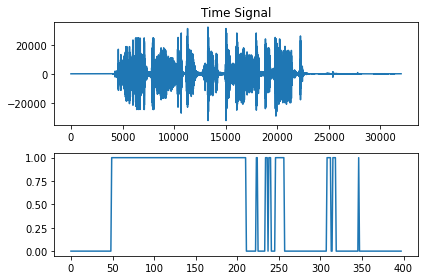

In [8]:
path_clean = '1055_tst_td_b_0081.wav'

path_wav = os.path.join(os.getcwd() , path_clean )
(sr, signal) = wav.read(path_wav)

vad=VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.99)

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Time Signal')

plt.subplot(2, 1, 2)
plt.plot(vad)


plt.tight_layout()
plt.show()

In [14]:
y2.size

14400

Text(0, 0.5, 'Amplitude')

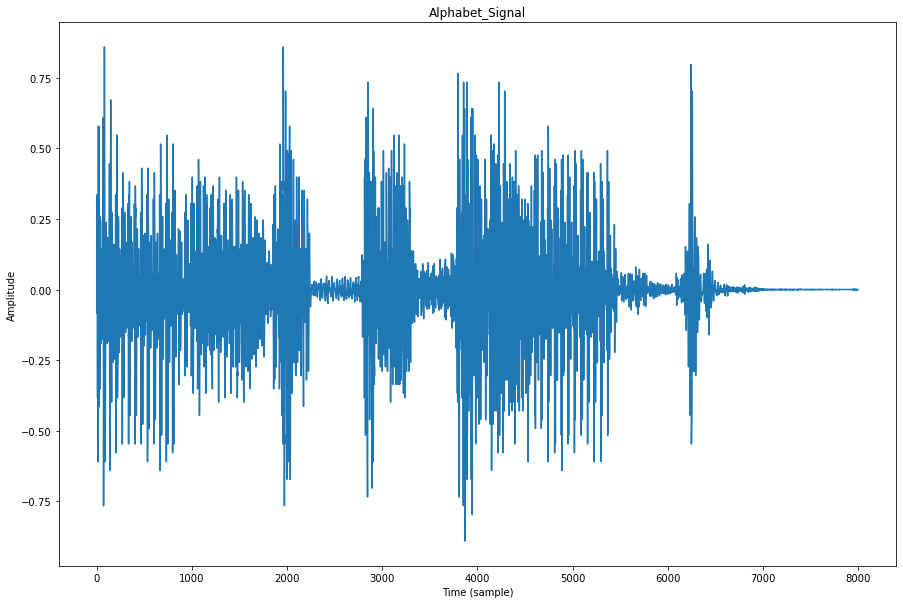

In [15]:
D="out1in2.wav"
y , sr =librosa.load(D,sr=8000) 

plt.figure(figsize=(15,10))
plt.plot(y)
plt.title('Alphabet_Signal')
plt.xlabel('Time (sample)')
plt.ylabel('Amplitude')

In [4]:
sr

8000

In [20]:
FRAME_SIZE =16
HOP_SIZE=8

Y2 = librosa.stft(y, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
Y2.shape

(9, 1801)

In [21]:
Y2 = np.abs(Y2) ** 2
Y2.shape

(9, 1801)

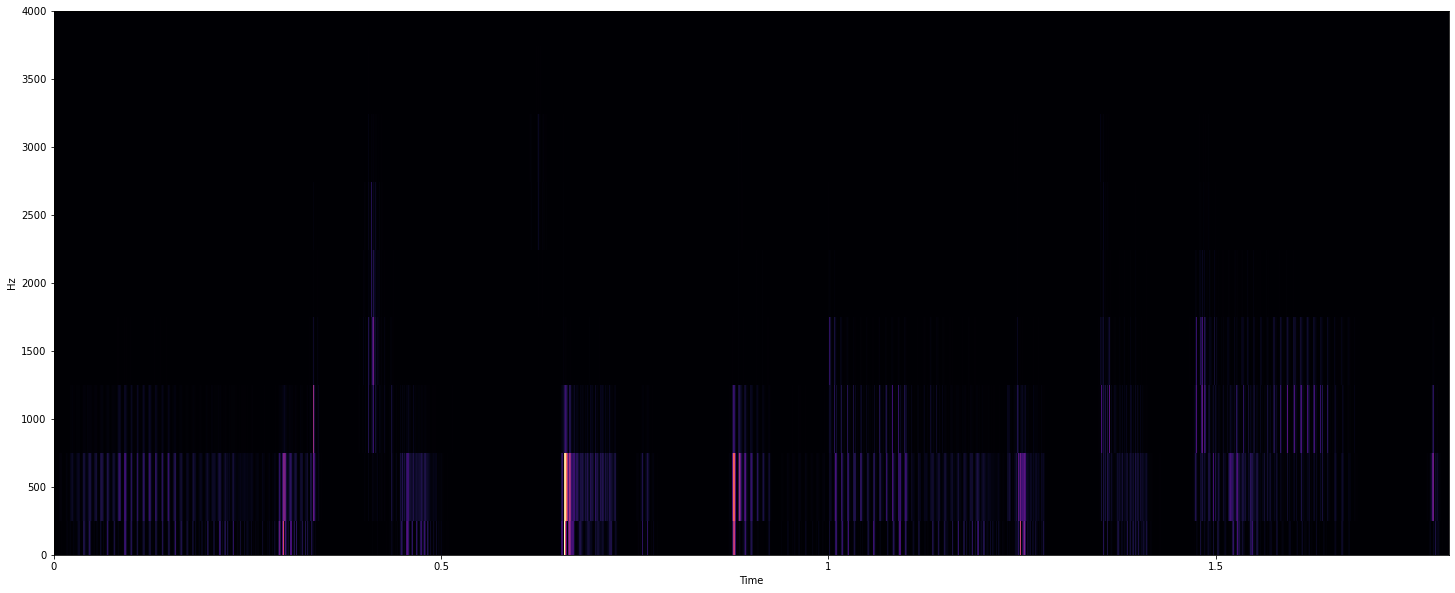

In [22]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(Y2,sr=sr,hop_length=HOP_SIZE,x_axis="time",y_axis="linear")
#plt.colorbar(format="%+2.f")

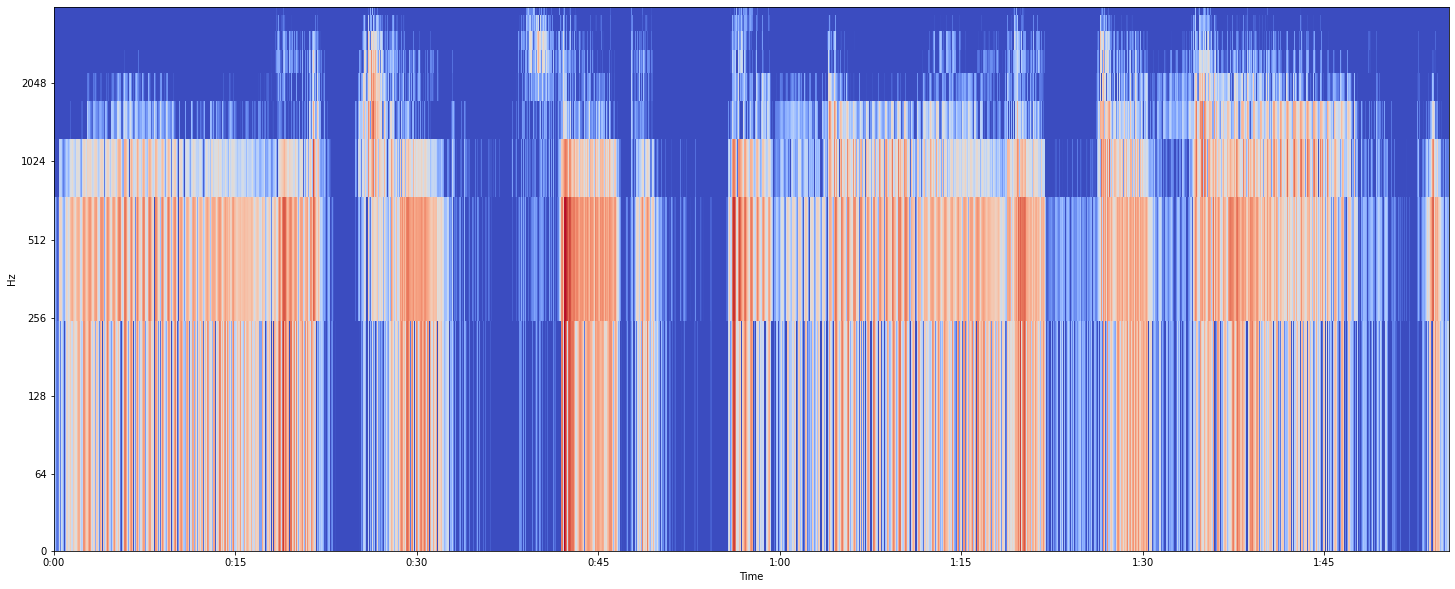

In [23]:
Y_duke = librosa.power_to_db(np.abs(Y2) ** 2)
plt.figure(figsize=(25, 10))
librosa.display.specshow(Y_duke, x_axis="time",y_axis="log",sr=sr)


In [9]:
mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=512, hop_length=128, n_mels=10)

In [10]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

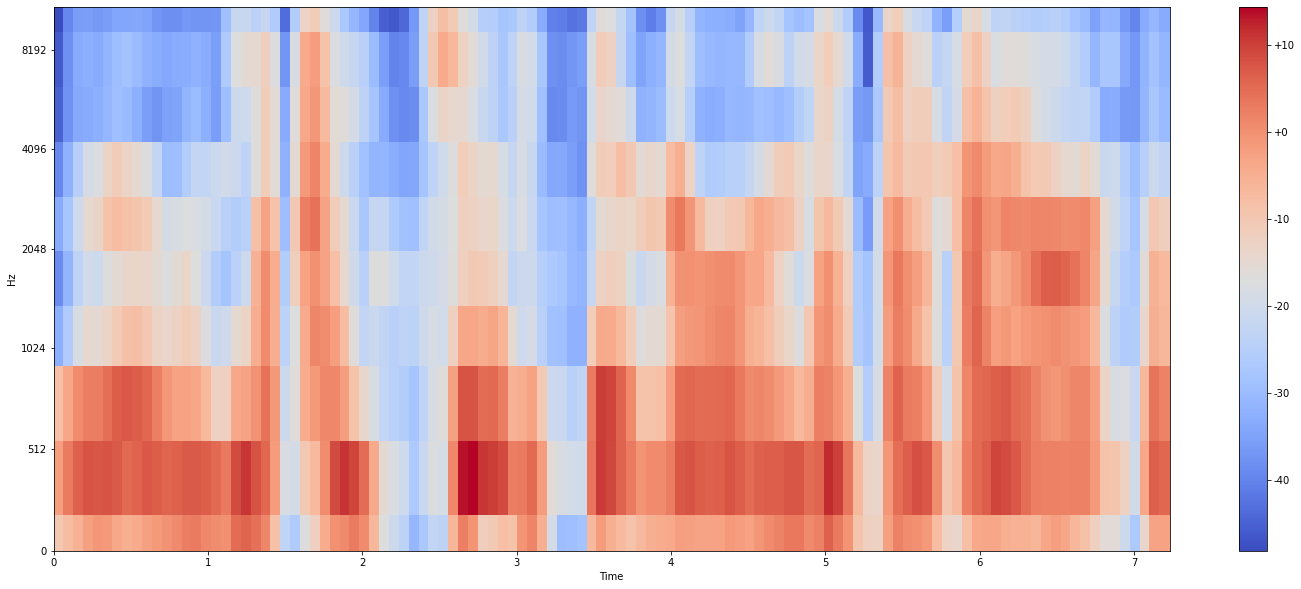

In [24]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, x_axis="time",y_axis="mel",sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [48]:
import decimal

import numpy
import math
import logging


def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))


def rolling_window(a, window, step=1):
    # http://ellisvalentiner.com/post/2017-03-21-np-strides-trick
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]


def framesig(sig, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames.
    :param sig: the audio signal to frame.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :param stride_trick: use stride trick to compute the rolling window and window multiplication faster
    :returns: an array of frames. Size is NUMFRAMES by frame_len.
    """
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step))

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = numpy.zeros((padlen - slen,))
    padsignal = numpy.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
            numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = numpy.array(indices, dtype=numpy.int32)
        frames = padsignal[indices]
        win = numpy.tile(winfunc(frame_len), (numframes, 1))

    return frames * win


def deframesig(frames, siglen, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,))):
    """Does overlap-add procedure to undo the action of framesig.
    :param frames: the array of frames.
    :param siglen: the length of the desired signal, use 0 if unknown. Output will be truncated to siglen samples.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :returns: a 1-D signal.
    """
    frame_len = round_half_up(frame_len)
    frame_step = round_half_up(frame_step)
    numframes = numpy.shape(frames)[0]
    assert numpy.shape(frames)[1] == frame_len, '"frames" matrix is wrong size, 2nd dim is not equal to frame_len'

    indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
        numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
    indices = numpy.array(indices, dtype=numpy.int32)
    padlen = (numframes - 1) * frame_step + frame_len

    if siglen <= 0: siglen = padlen

    rec_signal = numpy.zeros((padlen,))
    window_correction = numpy.zeros((padlen,))
    win = winfunc(frame_len)

    for i in range(0, numframes):
        window_correction[indices[i, :]] = window_correction[
                                               indices[i, :]] + win + 1e-15  # add a little bit so it is never zero
        rec_signal[indices[i, :]] = rec_signal[indices[i, :]] + frames[i, :]

    rec_signal = rec_signal / window_correction
    return rec_signal[0:siglen]


def magspec(frames, NFFT):
    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """
    if numpy.shape(frames)[1] > NFFT:
        logging.warn(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            numpy.shape(frames)[1], NFFT)
    complex_spec = numpy.fft.rfft(frames, NFFT)
    return numpy.absolute(complex_spec)


def powspec(frames, NFFT):
    """Compute the power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the power spectrum of the corresponding frame.
    """
    return 1.0 / NFFT * numpy.square(magspec(frames, NFFT))


def logpowspec(frames, NFFT, norm=1):
    """Compute the log power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :param norm: If norm=1, the log power spectrum is normalised so that the max value (across all frames) is 0.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the log power spectrum of the corresponding frame.
    """
    ps = powspec(frames, NFFT);
    ps[ps <= 1e-30] = 1e-30
    lps = 10 * numpy.log10(ps)
    if norm:
        return lps - numpy.max(lps)
    else:
        return lps


def preemphasis(signal, coeff=0.95):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.95.
    :returns: the filtered signal.
    """
    return numpy.append(signal[0], signal[1:] - coeff * signal[:-1])

In [47]:
from __future__ import division
import numpy
from python_speech_features import sigproc
from scipy.fftpack import dct

def calculate_nfft(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.
    
    Having an FFT less than the window length loses precision by dropping
    many of the samples; a longer FFT than the window allows zero-padding
    of the FFT buffer which is neutral in terms of frequency domain conversion.
    :param samplerate: The sample rate of the signal we are working with, in Hz.
    :param winlen: The length of the analysis window in seconds.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft

def mfcc(signal,samplerate=16000,winlen=0.025,winstep=0.01,numcep=13,
         nfilt=26,nfft=None,lowfreq=0,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True,
         winfunc=lambda x:numpy.ones((x,))):
    """Compute MFCC features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is None, which uses the calculate_nfft function to choose the smallest size that does not drop sample data.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    nfft = nfft or calculate_nfft(samplerate, winlen)
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    feat = lifter(feat,ceplifter)
    if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy
    return feat

def fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,))):
    """Compute Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = sigproc.powspec(frames,nfft)
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log

    return feat,energy

def logfbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
             nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
             winfunc=lambda x:numpy.ones((x,))):
    """Compute log Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    return numpy.log(feat)

def ssc(signal,samplerate=16000,winlen=0.025,winstep=0.01,
        nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
        winfunc=lambda x:numpy.ones((x,))):
    """Compute Spectral Subband Centroid features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = sigproc.powspec(frames,nfft)
    pspec = numpy.where(pspec == 0,numpy.finfo(float).eps,pspec) # if things are all zeros we get problems

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    R = numpy.tile(numpy.linspace(1,samplerate/2,numpy.size(pspec,1)),(numpy.size(pspec,0),1))

    return numpy.dot(pspec*R,fb.T) / feat

def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * numpy.log10(1+hz/700.)

def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = numpy.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = numpy.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L/2.)*numpy.sin(numpy.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra

def delta(feat, N):
    """Compute delta features from a feature vector sequence.
    :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    """
    if N < 1:
        raise ValueError('N must be an integer >= 1')
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = numpy.empty_like(feat)
    padded = numpy.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = numpy.dot(numpy.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat

Text(0, 0.5, 'Abs Magnitude')

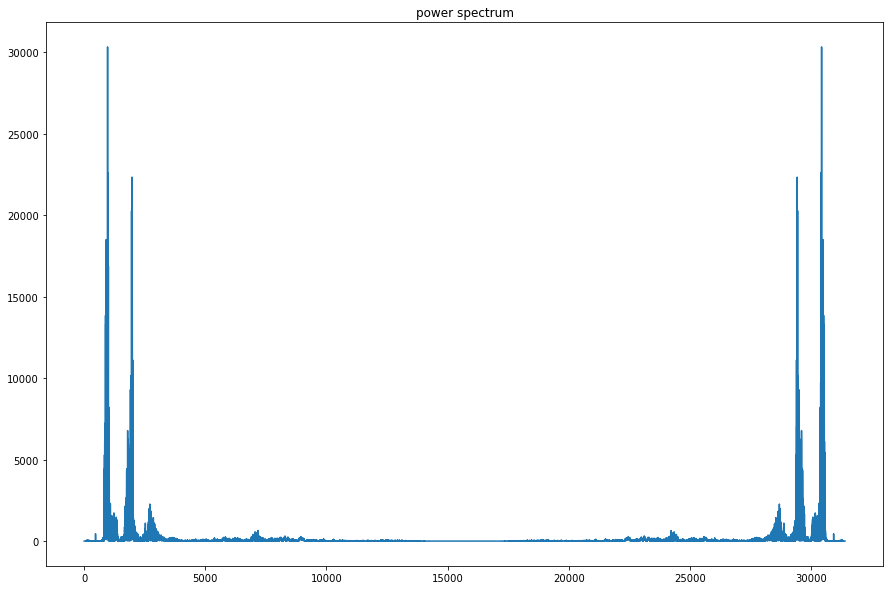

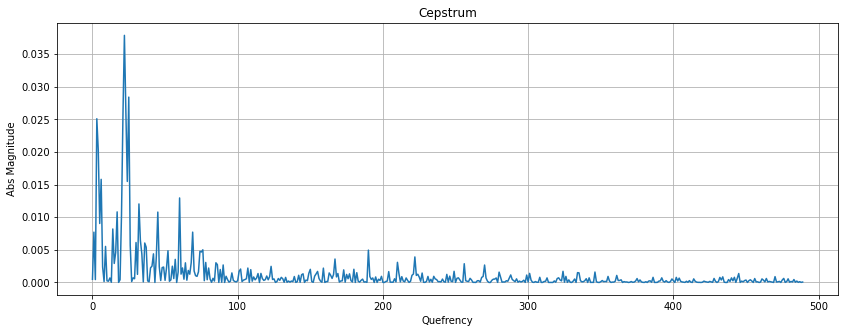

In [62]:
powerspectrum = np.abs(np.fft.fft(y2))**2
cepst = np.fft.ifft(np.log(powerspectrum))
cepst=np.abs(cepst)**2

plt.figure(figsize=(15, 10))
#plt.xlim(1000,5000)
plt.title("power spectrum")
plt.plot(powerspectrum)

n0 = 10
n1 = 500
plt.figure(figsize=(14, 5))
plt.plot(cepst[n0:n1])
plt.grid()
plt.title("Cepstrum")
plt.xlabel("Quefrency")
plt.ylabel("Abs Magnitude")

In [30]:
import python_speech_features
from python_speech_features import mfcc
import scipy.io.wavfile as wav

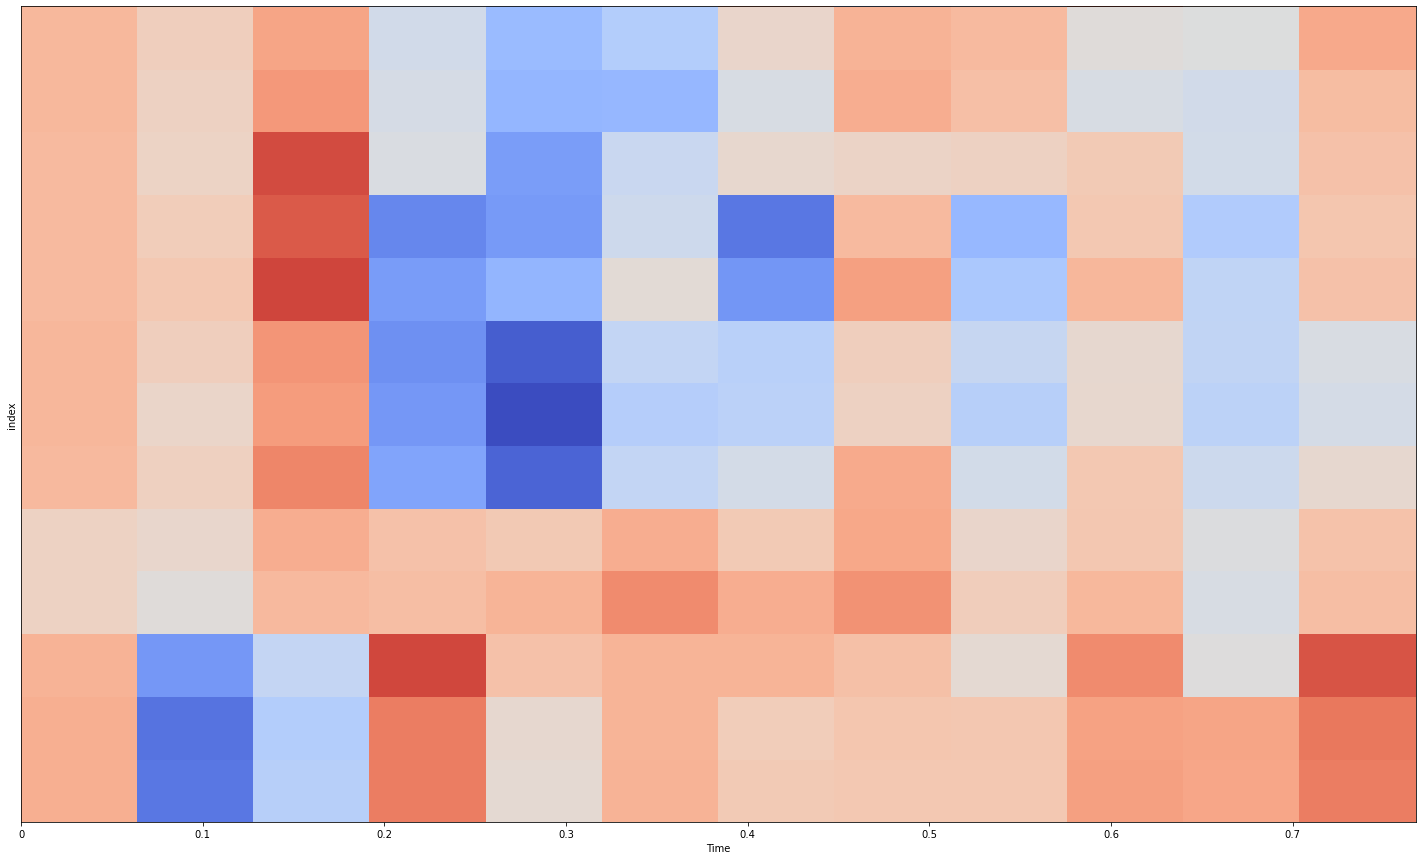

In [31]:
MFCC = python_speech_features.base.mfcc(y, samplerate=sr, winlen=0.25,winstep=0.1, numcep=12,nfft=2048)

plt.figure(figsize=(25,15))
librosa.display.specshow( MFCC,sr=sr,x_axis="time")
plt.ylim((0,13))
plt.ylabel("index")
plt.show()

In [23]:
MFCC =librosa.feature.mfcc( y=y , n_mfcc=12 , sr=sr ) #,dct_type=3,htk=True)
MFCC.shape

(12, 62)

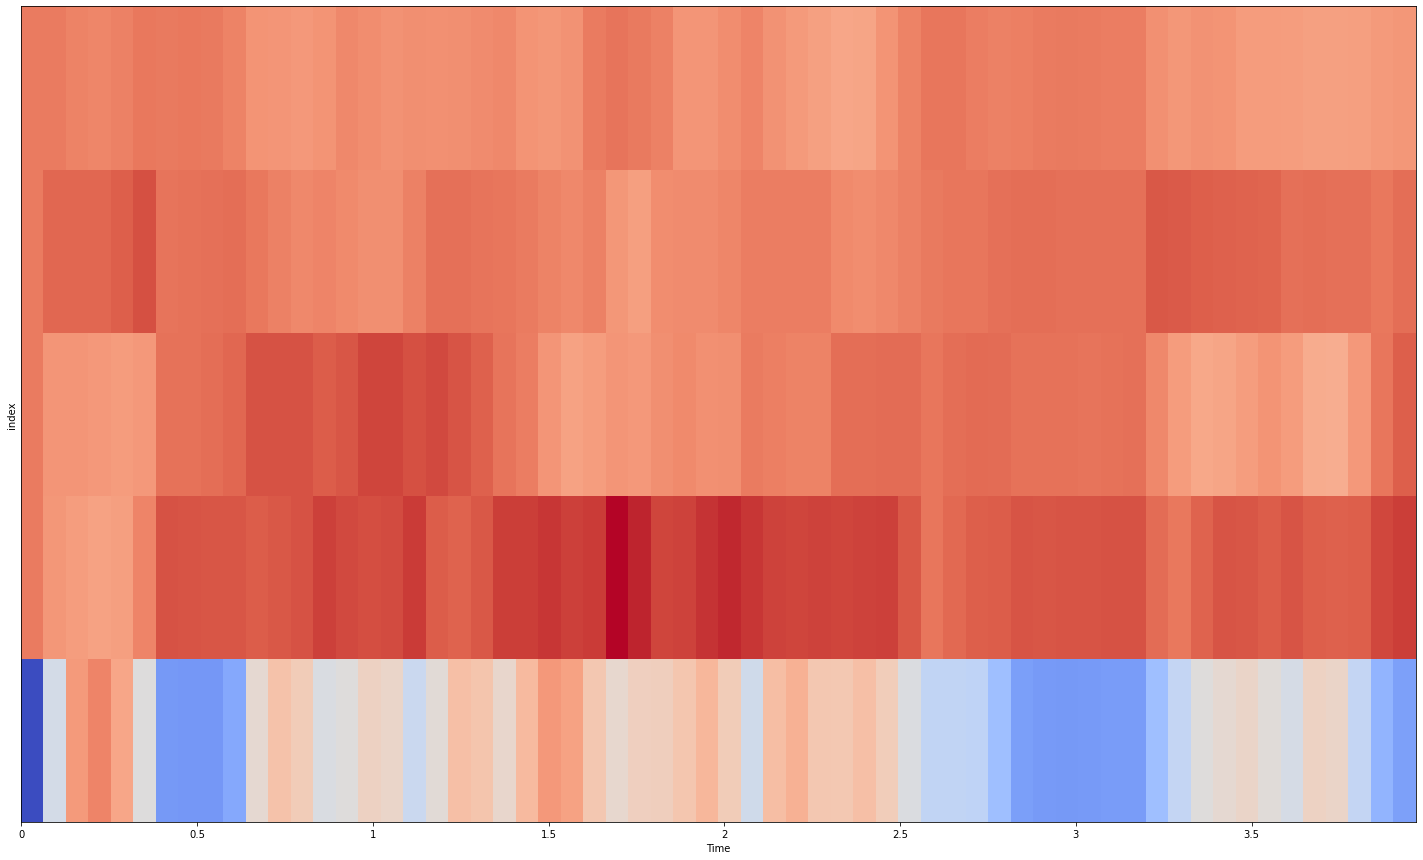

In [24]:
plt.figure(figsize=(25,15))
librosa.display.specshow( MFCC ,sr=sr, x_axis ="time"  )
plt.ylabel("index")
plt.ylim((0,5))
plt.show()

In [25]:
D_MFCC1 = librosa.feature.delta(MFCC)

In [26]:
D_MFCC2 =librosa.feature.delta(MFCC, order =2)

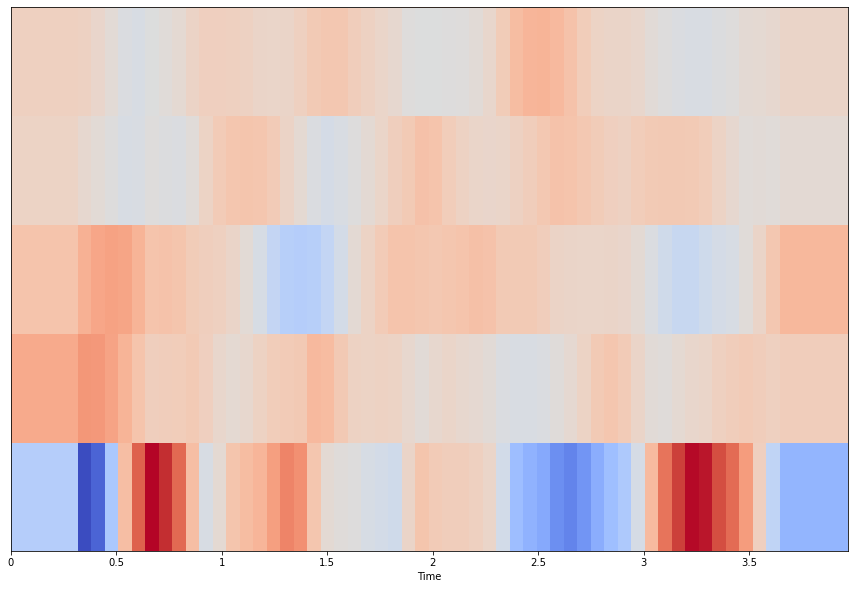

In [27]:
plt.figure(figsize=(15,10))
librosa.display.specshow(D_MFCC1 , x_axis="time", sr=sr )
plt.ylim((0,5))
plt.show()

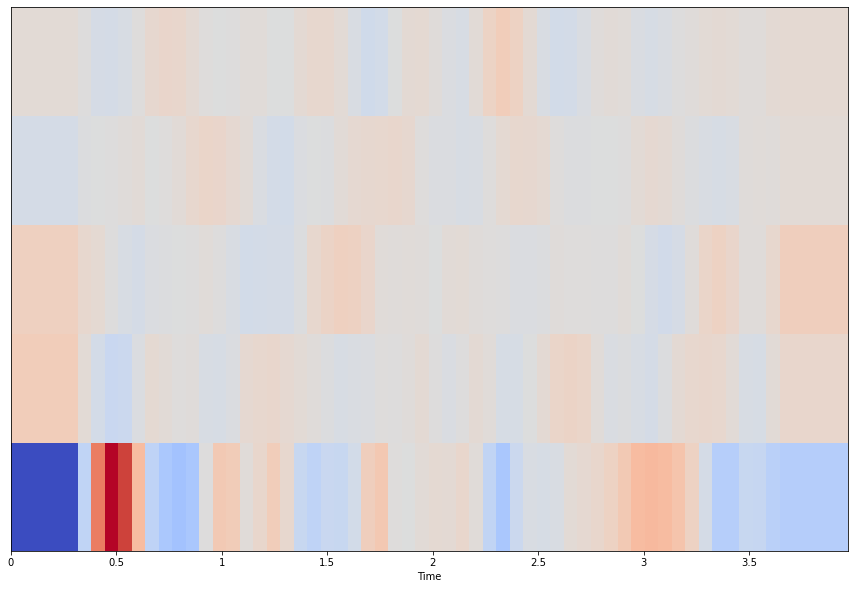

In [28]:
plt.figure(figsize=(15,10))
librosa.display.specshow(D_MFCC2 , x_axis="time", sr=sr )

plt.ylim((0,5))
plt.show()

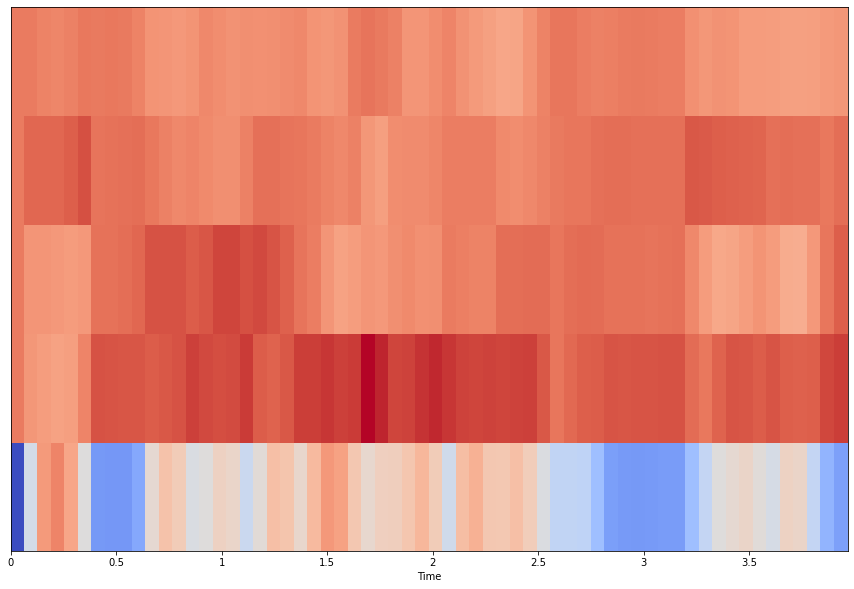

In [29]:
MFCC_CONC = np.concatenate((MFCC, D_MFCC1, D_MFCC2))
plt.figure(figsize=(15,10))
librosa.display.specshow(MFCC_CONC , x_axis="time", sr=sr )
plt.ylim((0,5))
plt.show()